In [1]:
# L_level_change
import pandas as pd
import numpy as np

# Define a function to keep the original format as a string
def keep_original_format(x):
    return str(x)
# Load the Excel file and use the converter for the "Duration (min:sec)" column
file_path = 'student4/s4_label_with_clusters_all.xlsx'
df = pd.read_excel(file_path, converters={'outcome': keep_original_format})


In [2]:
df['end_time'] = df['end_time'].ffill()

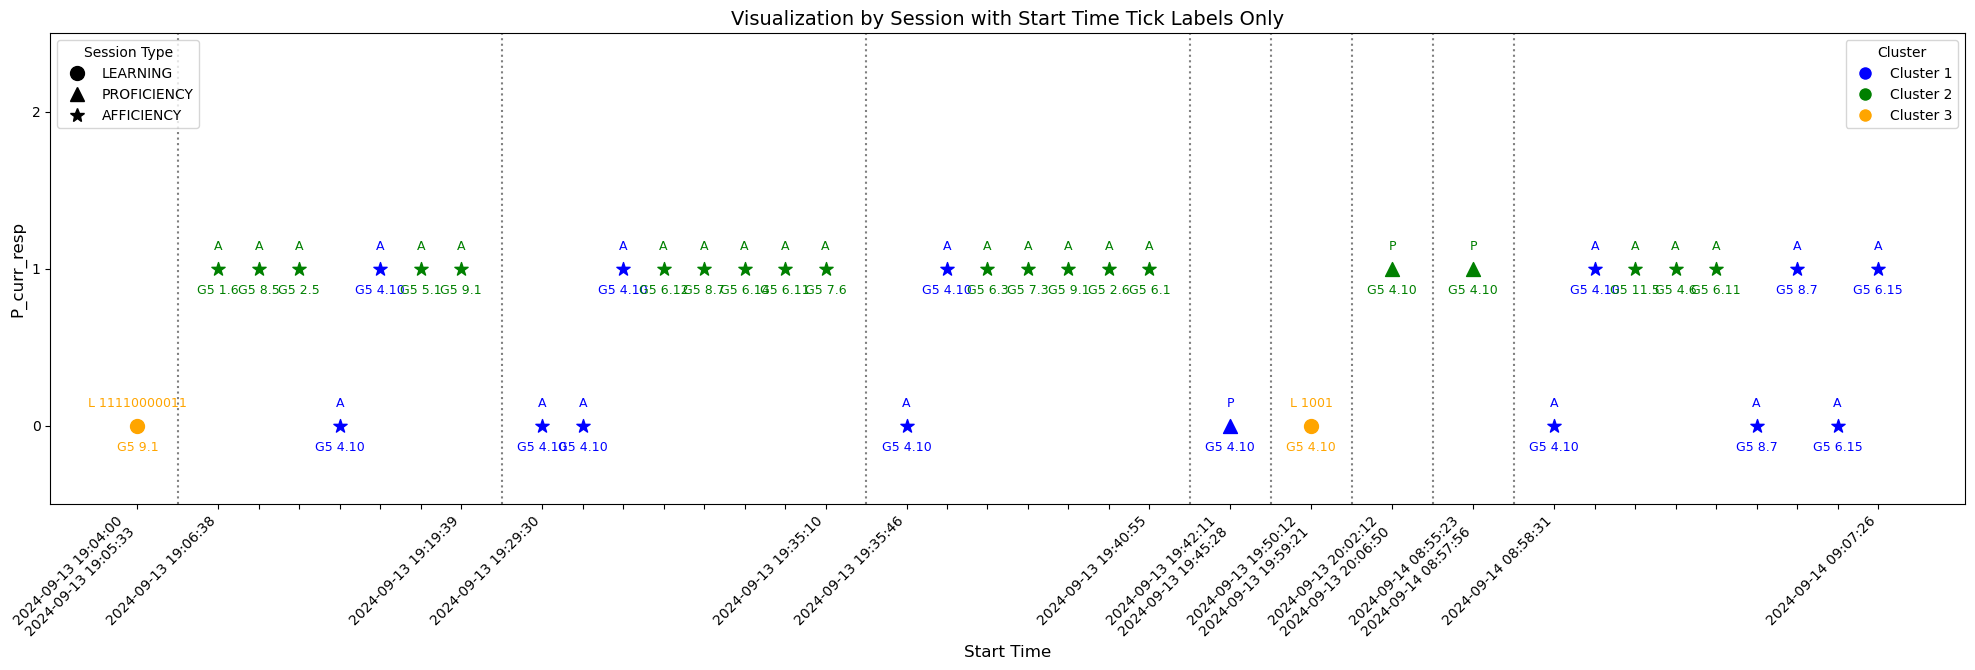

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Data Preprocessing ---
# (Assume df is already defined with columns: start_time, end_time, skill, session, outcome, P_curr_resp, Cluster_HC)
df['start_time'] = df['start_time'].astype(str)
df['end_time']   = df['end_time'].astype(str)
df['start_time_dt'] = pd.to_datetime(df['start_time'])
df['end_time_dt']   = pd.to_datetime(df['end_time'])

# --- Specify a time period ---
start_period = '2024-09-13 19:00:00'
end_period   = '2024-09-14 9:00:00'
mask = (df['start_time_dt'] >= pd.to_datetime(start_period)) & (df['start_time_dt'] <= pd.to_datetime(end_period))
df_period = df.loc[mask].copy()

# # Reset the index so that positions are sequential
# df_period.reset_index(drop=True, inplace=True)

# --- Build new x_positions with extra gaps if the current start_time is not equal to the previous one ---
new_x_positions = []
current_x = 0
new_x_positions.append(current_x)

for i in range(1, len(df_period)):
    prev_time = df_period['start_time_dt'].iloc[i-1]
    curr_time = df_period['start_time_dt'].iloc[i]
    blanks = 1 if curr_time != prev_time else 0
    current_x += 1 + blanks
    new_x_positions.append(current_x)

# --- Prepare custom x-axis tick labels and flags for drawing lines ---
tick_labels = [''] * len(df_period)
draw_line_flags = [False] * len(df_period)
# Group rows by start_time_dt (preserving order)
for group_val, group in df_period.groupby('start_time_dt', sort=False):
    group_indices = group.index.tolist()
    if len(group_indices) == 1:
        # One marker: combine start and end times; mark it as a start marker (draw line)
        idx = group_indices[0]
        tick_labels[idx] = (f"{group['start_time_dt'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')}\n"
                            f"{group['end_time_dt'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')}")
        draw_line_flags[idx] = True
    else:
        # First marker gets the start time and flag for drawing the line
        first_idx = group_indices[0]
        tick_labels[first_idx] = group['start_time_dt'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')
        draw_line_flags[first_idx] = True
        # Last marker gets the end time but no gray line is drawn for it
        last_idx = group_indices[-1]
        tick_labels[last_idx] = group['end_time_dt'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')

# --- Plotting ---
fig, ax = plt.subplots(figsize=(20, 8))

offset = 1  # adjust this value to shift the line position if needed
# Draw vertical dotted gray lines only for markers flagged for start_time
for idx, (x, draw_line) in enumerate(zip(new_x_positions, draw_line_flags)):
    if idx == 0:
        continue  # Skip the first position if desired
    if draw_line:
        ax.axvline(x=x - offset, color='gray', linestyle=':', zorder=0)

# Plot each marker and add annotations as before.
for i, row in enumerate(df_period.itertuples(index=False)):
    x = new_x_positions[i]  # Custom x-axis position
    session = row.session
    skill   = row.skill
    cluster = row.Cluster_HC

    marker = None
    color  = None
    label_lower = ""
    y_coord = 0  # Default y for LEARNING

    if session == "LEARNING":
        marker = "o"  # circle marker
        if cluster == 2:
            color = 'green'
        elif cluster == 1:
            color = 'blue'
        elif cluster == 3:
            color = 'orange'
        label_lower = f"{skill}"
        y_coord = 0  # LEARNING events on baseline
        label_upper = "L " + str(row.outcome)
    elif session == "PROFICIENCY":
        marker = "^"  # triangle marker
        if cluster == 2:
            color = 'green'
        elif cluster == 1:
            color = 'blue'
        label_lower = f"{skill}"
        y_coord = row.P_curr_resp
        label_upper = "P"
    elif session == "AFFICIENCY":
        marker = "*"  # star marker
        if cluster == 2:
            color = 'green'
        elif cluster == 1:
            color = 'blue'
        label_lower = f"{skill}"
        y_coord = row.P_curr_resp
        label_upper = "A"
    else:
        continue  # Skip unknown session types

    # Plot marker and add annotations
    ax.scatter(x, y_coord, marker=marker, color=color, s=100, zorder=3)
    ax.text(x, y_coord - 0.1, label_lower, ha='center', va='top', fontsize=9, color=color)
    if label_upper:
        ax.text(x, y_coord + 0.1, label_upper, ha='center', va='bottom', fontsize=9, color=color)

# --- X-axis: Set ticks and our custom labels ---
ax.set_xticks(new_x_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=10)

# --- Y-axis and other plot details ---
ax.set_yticks([0, 1, 2])
ax.set_xlabel("Start Time", fontsize=12)
ax.set_ylabel("P_curr_resp", fontsize=12)
ax.set_title("Visualization by Session with Start Time Tick Labels Only", fontsize=14)
ax.set_ylim(bottom=-0.5, top=2.5)

# --- Legends ---
session_handles = [
    Line2D([0], [0], marker='o', color='black', linestyle='', markersize=10, label='LEARNING'),
    Line2D([0], [0], marker='^', color='black', linestyle='', markersize=10, label='PROFICIENCY'),
    Line2D([0], [0], marker='*', color='black', linestyle='', markersize=10, label='AFFICIENCY')
]
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', linestyle='', markersize=10, label='Cluster 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', linestyle='', markersize=10, label='Cluster 2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', linestyle='', markersize=10, label='Cluster 3')
]
legend_sessions = ax.legend(handles=session_handles, loc='upper left', title="Session Type")
legend_clusters = ax.legend(handles=cluster_handles, loc='upper right', title="Cluster")
ax.add_artist(legend_sessions)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()
